# Telework and Productivity - Econometric Analysis

## 1. Introduction

This notebook presents an empirical analysis of the impact of teleworking on worker productivity in France.

Using INSEE labor market data (Enquête Emploi en Continu, 2019–2021), productivity is proxied by hourly wages.
The objective is to assess whether telework is associated with higher productivity while controlling for individual and job-related characteristics.

The analysis follows a standard econometric approach, including baseline OLS estimations, robustness checks, and a correction for selection bias using a Heckman two-step model.


## 2. Data loading

The data used in this analysis come from the INSEE Enquête Emploi en Continu (EEC).

*Due to data confidentiality, the raw datasets are not included in this repository.
The following steps assume that the data have been locally loaded and merged prior to analysis.*


## 3. Data preparation

This section describes the data cleaning and preparation steps applied before estimation.

The main steps include:
- construction of hourly wages from monthly wages and working hours,
- recoding of the telework variable into a binary indicator,
- removal of missing and extreme values,
- log-transformation of wages,
- creation of control variables and sector dummies.

In [1]:
import numpy as np

# On garde les individus qui ont un salaire et ont travaillé
df = df[
    ((df["ANNEE"] <= 2020) & df["SALRED"].notna() & df["HHC"].notna() & (df["HHC"] > 0)) |
    ((df["ANNEE"] >= 2021) & df["SALRED_Y"].notna() & df["HHABEMP"].notna() & (df["HHABEMP"] > 0))
]

# Création de la variable salaire horaire ajustée
df["Salaire_horaire"] = np.where(
    df["ANNEE"] <= 2020,
    df["SALRED"] / (df["HHC"] * 4.33),
    df["SALRED_Y"] / (df["HHABEMP"] * 4.33)
)

df.head()

NameError: name 'df' is not defined

In [ ]:
# Conversion de NOI en string avec padding sur 2 chiffres (01, 02, etc.)
df["NOI_str"] = df["NOI"].astype(int).astype(str).str.zfill(2)

# Concaténation avec IDENT pour former un identifiant unique
df["ID_individu"] = df["IDENT"] + "_" + df["NOI_str"]

df.head()

,ANNEE,IDENT,NOI,AGE,RGI,SEXE,NAFG010UN,HHC,MAISOC,SALRED,HHABEMP,TELETRAV_Y,SALRED_Y,Salaire_horaire,NOI_str,ID_individu
7,2019,H006442T,1,57,6.0,2,OQ,40.0,4.0,1956.0,NaN,NaN,NaN,11.293303,01,H006442T_01
8,2019,H006442T,2,56,6.0,1,MN,50.0,4.0,3249.0,NaN,NaN,NaN,15.006928,02,H006442T_02
9,2019,H0064E2T,1,60,6.0,1,KZ,38.0,4.0,3037.0,NaN,NaN,NaN,18.457518,01,H0064E2T_01
23,2019,H00D1KPL,1,36,5.0,2,MN,37.5,4.0,2000.0,NaN,NaN,NaN,12.317167,01,H00D1KPL_01
24,2019,H00D1KPL,2,39,5.0,1,MN,50.0,4.0,4500.0,NaN,NaN,NaN,20.785219,02,H00D1KPL_02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1078984,2021,JZAM053F,2,52,1.0,1,GI,NaN,NaN,NaN,35.0,2.0,1600.0,10.557572,02,JZAM053F_02
1078985,2021,JF7Z1XMW,1,54,1.0,2,OQ,NaN,NaN,NaN,35.0,2.0,2400.0,15.836358,01,JF7Z1XMW_01
1078989,2021,JFGZ16MV,2,35,1.0,1,GI,NaN,NaN,NaN,39.0,2.0,1261.0,7.467283,02,JFGZ16MV_02
1078998,2021,JIC80EKY,2,32,1.0,1,OQ,NaN,NaN,NaN,35.0,2.0,1600.0,10.557572,02,JIC80EKY_02


In [ ]:
# Création de la variable binaire "teletravail"
df["teletravail"] = np.where(
    ((df["ANNEE"] <= 2020) & df["MAISOC"].isin([1, 2, 3])) |
    ((df["ANNEE"] == 2021) & (df["TELETRAV_Y"] == 1)),
    1,  # Oui, a télétravaillé
    0   # Non
)

df.head()

,ANNEE,IDENT,NOI,AGE,RGI,SEXE,NAFG010UN,HHC,MAISOC,SALRED,HHABEMP,TELETRAV_Y,SALRED_Y,Salaire_horaire,NOI_str,ID_individu,teletravail
7,2019,H006442T,1,57,6.0,2,OQ,40.0,4.0,1956.0,NaN,NaN,NaN,11.293303,01,H006442T_01,0
8,2019,H006442T,2,56,6.0,1,MN,50.0,4.0,3249.0,NaN,NaN,NaN,15.006928,02,H006442T_02,0
9,2019,H0064E2T,1,60,6.0,1,KZ,38.0,4.0,3037.0,NaN,NaN,NaN,18.457518,01,H0064E2T_01,0
23,2019,H00D1KPL,1,36,5.0,2,MN,37.5,4.0,2000.0,NaN,NaN,NaN,12.317167,01,H00D1KPL_01,0
24,2019,H00D1KPL,2,39,5.0,1,MN,50.0,4.0,4500.0,NaN,NaN,NaN,20.785219,02,H00D1KPL_02,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1078984,2021,JZAM053F,2,52,1.0,1,GI,NaN,NaN,NaN,35.0,2.0,1600.0,10.557572,02,JZAM053F_02,0
1078985,2021,JF7Z1XMW,1,54,1.0,2,OQ,NaN,NaN,NaN,35.0,2.0,2400.0,15.836358,01,JF7Z1XMW_01,0
1078989,2021,JFGZ16MV,2,35,1.0,1,GI,NaN,NaN,NaN,39.0,2.0,1261.0,7.467283,02,JFGZ16MV_02,0
1078998,2021,JIC80EKY,2,32,1.0,1,OQ,NaN,NaN,NaN,35.0,2.0,1600.0,10.557572,02,JIC80EKY_02,0


In [ ]:
df = df.drop(columns=["IDENT"])
df = df.drop(columns=["NOI"])

df.head()

,ANNEE,AGE,RGI,SEXE,NAFG010UN,HHC,MAISOC,SALRED,HHABEMP,TELETRAV_Y,SALRED_Y,Salaire_horaire,NOI_str,ID_individu,teletravail
7,2019,57,6.0,2,OQ,40.0,4.0,1956.0,NaN,NaN,NaN,11.293303,01,H006442T_01,0
8,2019,56,6.0,1,MN,50.0,4.0,3249.0,NaN,NaN,NaN,15.006928,02,H006442T_02,0
9,2019,60,6.0,1,KZ,38.0,4.0,3037.0,NaN,NaN,NaN,18.457518,01,H0064E2T_01,0
23,2019,36,5.0,2,MN,37.5,4.0,2000.0,NaN,NaN,NaN,12.317167,01,H00D1KPL_01,0
24,2019,39,5.0,1,MN,50.0,4.0,4500.0,NaN,NaN,NaN,20.785219,02,H00D1KPL_02,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1078984,2021,52,1.0,1,GI,NaN,NaN,NaN,35.0,2.0,1600.0,10.557572,02,JZAM053F_02,0
1078985,2021,54,1.0,2,OQ,NaN,NaN,NaN,35.0,2.0,2400.0,15.836358,01,JF7Z1XMW_01,0
1078989,2021,35,1.0,1,GI,NaN,NaN,NaN,39.0,2.0,1261.0,7.467283,02,JFGZ16MV_02,0
1078998,2021,32,1.0,1,OQ,NaN,NaN,NaN,35.0,2.0,1600.0,10.557572,02,JIC80EKY_02,0


In [ ]:
#on garde les individus avec RGI = 1 et RGI = 6
#au début de l'enquête puis à la fin

df = df[df["RGI"].isin([1,6])]

df.head()

,ANNEE,AGE,RGI,SEXE,NAFG010UN,HHC,MAISOC,SALRED,HHABEMP,TELETRAV_Y,SALRED_Y,Salaire_horaire,NOI_str,ID_individu,teletravail
7,2019,57,6.0,2,OQ,40.0,4.0,1956.0,NaN,NaN,NaN,11.293303,01,H006442T_01,0
8,2019,56,6.0,1,MN,50.0,4.0,3249.0,NaN,NaN,NaN,15.006928,02,H006442T_02,0
9,2019,60,6.0,1,KZ,38.0,4.0,3037.0,NaN,NaN,NaN,18.457518,01,H0064E2T_01,0
31,2019,49,1.0,2,OQ,35.0,4.0,1366.0,NaN,NaN,NaN,9.013527,01,H00G44AQ_01,0
32,2019,46,1.0,1,FZ,50.0,4.0,1800.0,NaN,NaN,NaN,8.314088,02,H00G44AQ_02,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1078984,2021,52,1.0,1,GI,NaN,NaN,NaN,35.0,2.0,1600.0,10.557572,02,JZAM053F_02,0
1078985,2021,54,1.0,2,OQ,NaN,NaN,NaN,35.0,2.0,2400.0,15.836358,01,JF7Z1XMW_01,0
1078989,2021,35,1.0,1,GI,NaN,NaN,NaN,39.0,2.0,1261.0,7.467283,02,JFGZ16MV_02,0
1078998,2021,32,1.0,1,OQ,NaN,NaN,NaN,35.0,2.0,1600.0,10.557572,02,JIC80EKY_02,0


In [ ]:
# Liste des colonnes actuelles
cols = list(df.columns)

# On retire la colonne qu'on veut déplacer
cols.remove("ID_individu")

# On l’insère en 2e position
cols.insert(1, "ID_individu")

# Réorganisation du DataFrame
df = df[cols]

df.head()

,ANNEE,ID_individu,AGE,RGI,SEXE,NAFG010UN,HHC,MAISOC,SALRED,HHABEMP,TELETRAV_Y,SALRED_Y,Salaire_horaire,NOI_str,teletravail
7,2019,H006442T_01,57,6.0,2,OQ,40.0,4.0,1956.0,NaN,NaN,NaN,11.293303,01,0
8,2019,H006442T_02,56,6.0,1,MN,50.0,4.0,3249.0,NaN,NaN,NaN,15.006928,02,0
9,2019,H0064E2T_01,60,6.0,1,KZ,38.0,4.0,3037.0,NaN,NaN,NaN,18.457518,01,0
31,2019,H00G44AQ_01,49,1.0,2,OQ,35.0,4.0,1366.0,NaN,NaN,NaN,9.013527,01,0
32,2019,H00G44AQ_02,46,1.0,1,FZ,50.0,4.0,1800.0,NaN,NaN,NaN,8.314088,02,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1078984,2021,JZAM053F_02,52,1.0,1,GI,NaN,NaN,NaN,35.0,2.0,1600.0,10.557572,02,0
1078985,2021,JF7Z1XMW_01,54,1.0,2,OQ,NaN,NaN,NaN,35.0,2.0,2400.0,15.836358,01,0
1078989,2021,JFGZ16MV_02,35,1.0,1,GI,NaN,NaN,NaN,39.0,2.0,1261.0,7.467283,02,0
1078998,2021,JIC80EKY_02,32,1.0,1,OQ,NaN,NaN,NaN,35.0,2.0,1600.0,10.557572,02,0


In [ ]:
df.to_csv("/Users/alicia/Desktop/Mémoire/Base_données_finale.csv", index=False, sep=";")
print("Base finale enregistrée avec succès !")



✅ Base finale enregistrée avec succès !


## 4. Exploratory analysis

In [ ]:
#graph du salaire horaire moyen par année et en fonction de la modalité du travail
#graph de la modalité du travail en fonction du secteur


In [ ]:
# On va créer des statistiques descriptives par secteur (NAFG010UN)
# et croiser avec une variable directement liée à la productivité : Salaire horaire
# On obtient donc : productivité moyenne par secteur

# Sélection des variables nécessaires
df_prod_secteur = df[['NAFG010UN', 'Salaire_horaire']].dropna()

# Calcul de la productivité moyenne par secteur
stats_prod_par_secteur = df_prod_secteur.groupby('NAFG010UN').agg(
    Moyenne_salaire_horaire=('Salaire_horaire', 'mean'),
    Ecart_type=('Salaire_horaire', 'std'),
    Effectif=('Salaire_horaire', 'count')
).reset_index().sort_values(by='Moyenne_salaire_horaire', ascending=False)

# Conversion du tableau en LaTeX
x = stats_prod_par_secteur.to_latex(
    index=False,
    float_format="%.2f",
    caption="Productivité horaire moyenne par secteur d’activité",
    label="tab:prod_par_secteur"
)

# Affichage du code LaTeX
print(x)

stats_prod_par_secteur


\begin{table}
\caption{Productivité horaire moyenne par secteur d’activité}
\label{tab:prod_par_secteur}
\begin{tabular}{lrrr}
\toprule
NAFG010UN & Moyenne_salaire_horaire & Ecart_type & Effectif \\
\midrule
JZ & 17.58 & 23.44 & 3020 \\
KZ & 16.93 & 10.64 & 3595 \\
BE & 13.89 & 8.99 & 14622 \\
MN & 13.69 & 10.16 & 9106 \\
LZ & 12.84 & 11.30 & 996 \\
OQ & 12.61 & 7.39 & 36148 \\
FZ & 11.96 & 5.67 & 5935 \\
RU & 11.92 & 10.14 & 5364 \\
00 & 11.79 & 5.87 & 1267 \\
GI & 11.71 & 8.07 & 21435 \\
AZ & 9.64 & 5.14 & 1284 \\
\bottomrule
\end{tabular}
\end{table}



,NAFG010UN,Moyenne_salaire_horaire,Ecart_type,Effectif
5,JZ,17.577349,23.439403,3020
6,KZ,16.928929,10.640612,3595
2,BE,13.893805,8.987658,14622
8,MN,13.694501,10.162888,9106
7,LZ,12.844815,11.300790,996
9,OQ,12.611559,7.392941,36148
3,FZ,11.964461,5.669707,5935
10,RU,11.922662,10.140583,5364
0,00,11.785817,5.868759,1267
4,GI,11.707814,8.073670,21435


In [ ]:
pd.crosstab(df['ANNEE'], df['teletravail'], normalize='index') * 100


teletravail,0,1
ANNEE,,
2019,82.385381,17.614619
2020,75.590811,24.409189
2021,78.601001,21.398999


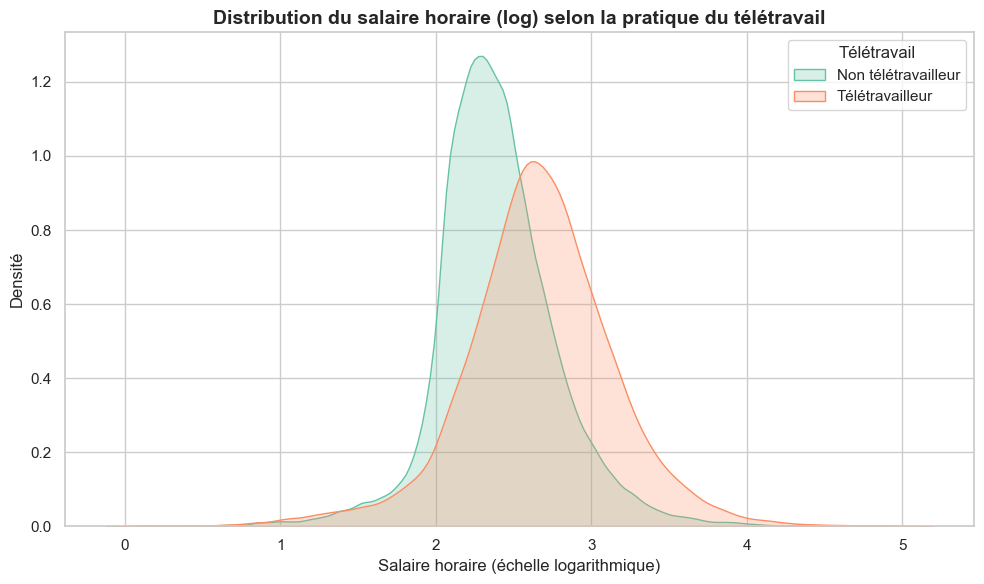

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Nettoyage et filtrage plus propre
df_clean = df.copy()
df_clean["Salaire_horaire"] = pd.to_numeric(df_clean["Salaire_horaire"], errors="coerce")
df_clean["teletravail"] = pd.to_numeric(df_clean["teletravail"], errors="coerce")

# Garder uniquement les salaires réalistes (entre 1€ et 150€/h)
df_clean = df_clean[(df_clean["Salaire_horaire"] > 1) & (df_clean["Salaire_horaire"] <= 150)]
df_clean = df_clean.dropna(subset=["Salaire_horaire", "teletravail"])

# Séparer les deux groupes
df_non = df_clean[df_clean["teletravail"] == 0]["Salaire_horaire"]
df_oui = df_clean[df_clean["teletravail"] == 1]["Salaire_horaire"]

# Graphique avec axe en échelle logarithmique
plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid")

# Tracer les distributions
sns.kdeplot(np.log(df_non), fill=True, label="Non télétravailleur", color="#66c2a5")
sns.kdeplot(np.log(df_oui), fill=True, label="Télétravailleur", color="#fc8d62")

# Ajustements esthétiques
plt.xlabel("Salaire horaire (échelle logarithmique)", fontsize=12)
plt.ylabel("Densité", fontsize=12)
plt.title("Distribution du salaire horaire (log) selon la pratique du télétravail", fontsize=14, weight='bold')
plt.legend(title="Télétravail")
plt.tight_layout()

# Sauvegarde
plt.savefig("kde_salaire_teletravail_log_ok.png")
plt.show()


/var/folders/cj/h0vy9gjs0vj1bgfrtp4gzbt40000gn/T/ipykernel_33957/3670690103.py:38: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_tt_final, x="Période", y="Salaire_horaire", ci=None, palette="pastel")


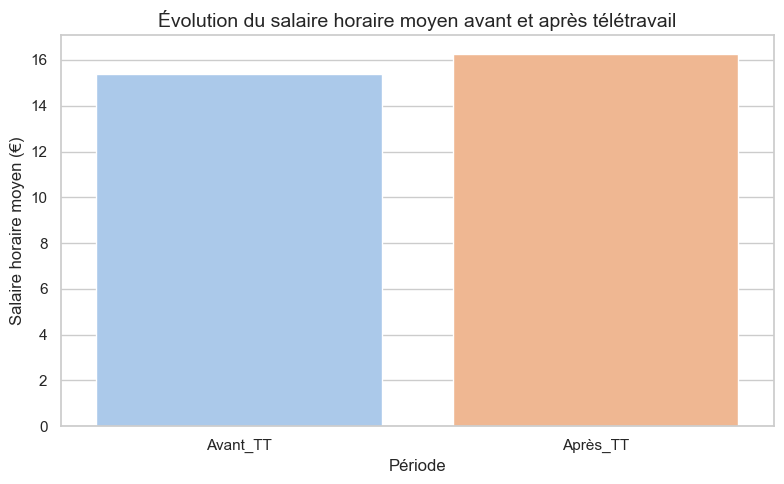

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Charger la base finale (celle avec Salaire_horaire et Période créée avant)
df = pd.read_csv("/Users/alicia/Desktop/Mémoire/Base_données_finale.csv", sep=";")

# Calculer le salaire horaire
df["Salaire_horaire"] = df["SALRED"] / (df["HHC"] * 4.33)

# Créer la variable télétravail par ligne
df["Teletravail_ligne"] = df["MAISOC"].isin([1, 2, 3]).astype(int)

# Garder les individus présents plusieurs années
ids_multi = df["ID_individu"].value_counts()[lambda x: x >= 2].index
df_multi = df[df["ID_individu"].isin(ids_multi)].copy()

# Repérer l'année de premier télétravail
first_tt = df_multi[df_multi["Teletravail_ligne"] == 1].groupby("ID_individu")["ANNEE"].min().reset_index()
first_tt.rename(columns={"ANNEE": "Annee_debut_teletravail"}, inplace=True)

# Fusionner
df_tt = df_multi.merge(first_tt, on="ID_individu", how="left")
df_tt = df_tt[~df_tt["Annee_debut_teletravail"].isna()]

# Période Avant / Après
df_tt["Période"] = df_tt.apply(
    lambda row: "Avant_TT" if row["ANNEE"] < row["Annee_debut_teletravail"]
    else ("Après_TT" if row["ANNEE"] > row["Annee_debut_teletravail"] else "Début_TT"),
    axis=1
)

# Garder seulement les vraies périodes Avant et Après
df_tt_final = df_tt[df_tt["Période"].isin(["Avant_TT", "Après_TT"])]

# ➤ Barplot salaire moyen par période
plt.figure(figsize=(8, 5))
sns.barplot(data=df_tt_final, x="Période", y="Salaire_horaire", ci=None, palette="pastel")

plt.title("Évolution du salaire horaire moyen avant et après télétravail", fontsize=14)
plt.xlabel("Période", fontsize=12)
plt.ylabel("Salaire horaire moyen (€)", fontsize=12)
plt.tight_layout()
plt.savefig("salaire_avant_apres_tt.png")
plt.show()

In [ ]:
# On garde uniquement les colonnes importantes
cols = ["Salaire_horaire", "AGE", "SEXE", "teletravail", "Secteur", "MAISOC"]
df_clean = df[cols].copy()

# Nettoyage basique
df_clean["Salaire_horaire"] = pd.to_numeric(df_clean["Salaire_horaire"], errors="coerce")
df_clean["AGE"] = pd.to_numeric(df_clean["AGE"], errors="coerce")
df_clean["teletravail"] = pd.to_numeric(df_clean["teletravail"], errors="coerce")
df_clean["SEXE"] = pd.to_numeric(df_clean["SEXE"], errors="coerce")

# Nombre d'observations
n = len(df_clean)

# Statistiques de base
stats = {
    "Salaire horaire moyen (€)": df_clean["Salaire_horaire"].mean(),
    "Salaire horaire médian (€)": df_clean["Salaire_horaire"].median(),
    "Salaire horaire écart-type": df_clean["Salaire_horaire"].std(),
    "Salaire horaire min (€)": df_clean["Salaire_horaire"].min(),
    "Salaire horaire max (€)": df_clean["Salaire_horaire"].max(),
    "Âge moyen": df_clean["AGE"].mean(),
    "Âge écart-type": df_clean["AGE"].std(),
    "Part d'hommes (%)": 100 * (df_clean["SEXE"] == 1).mean(),
    "Part de femmes (%)": 100 * (df_clean["SEXE"] == 2).mean(),
    "Part de télétravailleurs (%)": 100 * (df_clean["teletravail"] == 1).mean()
}

# Affichage
stats_df = pd.DataFrame(stats, index=["Statistiques générales"]).T
print(stats_df)

# Option pour enregistrer en CSV si besoin
stats_df.to_csv("Statistiques_Descriptives_Teletravail.csv")


                              Statistiques générales
Salaire horaire moyen (€)                  12.882393
Salaire horaire médian (€)                 11.217420
Salaire horaire écart-type                  9.117799
Salaire horaire min (€)                     0.002749
Salaire horaire max (€)                  1154.734411
Âge moyen                                  43.321421
Âge écart-type                             11.709396
Part d'hommes (%)                          48.654252
Part de femmes (%)                         51.345748
Part de télétravailleurs (%)               20.461399


In [ ]:
import pandas as pd

# Charger la base
df = pd.read_csv("/Users/alicia/Desktop/Mémoire/Base_données_finale.csv", sep=";")

# Variables qui nous intéressent pour les statistiques
variables_quantitatives = ["Salaire_horaire", "AGE", "HHC"]  # Salaire horaire, âge, heures travaillées
variables_qualitatives = ["SEXE", "CONTRAT", "Secteur", "teletravail"]  # Sexe, type de contrat, secteur, télétravail

# Statistiques descriptives pour les variables quantitatives
desc_quant = df[variables_quantitatives].describe()
print("🔵 Statistiques descriptives des variables quantitatives :\n")
print(desc_quant)

# Sta
latex_code = desc_quant.reset_index().to_latex(index=False, caption="Salaire horaire moyen selon le sexe, l'âge et la pratique du télétravail", label="tab:salaire_age_teletravail")
print(latex_code)




🔵 Statistiques descriptives des variables quantitatives :

       Salaire_horaire            AGE           HHC
count    102772.000000  102772.000000  79584.000000
mean         12.880021      43.143356     36.171479
std           9.206182      11.833633      9.467117
min           0.000000      15.000000      0.500000
25%           8.932982      34.000000     35.000000
50%          11.217420      44.000000     35.000000
75%          14.586119      53.000000     40.000000
max        1154.734411      87.000000     99.500000
\begin{table}
\caption{Salaire horaire moyen selon le sexe, l'âge et la pratique du télétravail}
\label{tab:salaire_age_teletravail}
\begin{tabular}{lrrr}
\toprule
index & Salaire_horaire & AGE & HHC \\
\midrule
count & 102772.000000 & 102772.000000 & 79584.000000 \\
mean & 12.880021 & 43.143356 & 36.171479 \\
std & 9.206182 & 11.833633 & 9.467117 \\
min & 0.000000 & 15.000000 & 0.500000 \\
25% & 8.932982 & 34.000000 & 35.000000 \\
50% & 11.217420 & 44.000000 & 35.0000

In [ ]:
import pandas as pd

# 1. Sélection des variables nécessaires
df_prod_secteur = df[['NAFG010UN', 'Salaire_horaire']].dropna()

# 2. Calcul de la productivité moyenne par secteur
stats_prod_par_secteur = df_prod_secteur.groupby('NAFG010UN').agg(
    Moyenne_salaire_horaire=('Salaire_horaire', 'mean'),
    Ecart_type=('Salaire_horaire', 'std'),
    Effectif=('Salaire_horaire', 'count')
).reset_index()

# 3. Transformer l'effectif en pourcentage
total = stats_prod_par_secteur['Effectif'].sum()
stats_prod_par_secteur['Effectif (%)'] = (stats_prod_par_secteur['Effectif'] / total) * 100

# 4. Supprimer la colonne brute 'Effectif' si tu ne veux garder que le pourcentage
stats_prod_par_secteur = stats_prod_par_secteur.drop(columns=['Effectif'])

# 5. Trier les secteurs du plus haut au plus bas salaire horaire moyen
stats_prod_par_secteur = stats_prod_par_secteur.sort_values(by='Moyenne_salaire_horaire', ascending=False)

# 6. Conversion du tableau en LaTeX
latex_table = stats_prod_par_secteur.to_latex(
    index=False,
    float_format="%.2f",
    caption="Productivité horaire moyenne par secteur d’activité (effectif en pourcentage)",
    label="tab:prod_par_secteur"
)

# 7. Affichage du code LaTeX
print(latex_table)

# 8. (Optionnel) Voir le DataFrame propre
stats_prod_par_secteur


\begin{table}
\caption{Productivité horaire moyenne par secteur d’activité (effectif en pourcentage)}
\label{tab:prod_par_secteur}
\begin{tabular}{lrrr}
\toprule
NAFG010UN & Moyenne_salaire_horaire & Ecart_type & Effectif (%) \\
\midrule
JZ & 17.58 & 23.44 & 2.94 \\
KZ & 16.93 & 10.64 & 3.50 \\
BE & 13.89 & 8.99 & 14.23 \\
MN & 13.69 & 10.16 & 8.86 \\
LZ & 12.84 & 11.30 & 0.97 \\
OQ & 12.61 & 7.39 & 35.17 \\
FZ & 11.96 & 5.67 & 5.77 \\
RU & 11.92 & 10.14 & 5.22 \\
00 & 11.79 & 5.87 & 1.23 \\
GI & 11.71 & 8.07 & 20.86 \\
AZ & 9.64 & 5.14 & 1.25 \\
\bottomrule
\end{tabular}
\end{table}



,NAFG010UN,Moyenne_salaire_horaire,Ecart_type,Effectif (%)
5,JZ,17.577349,23.439403,2.938544
6,KZ,16.928929,10.640612,3.498034
2,BE,13.893805,8.987658,14.227611
8,MN,13.694501,10.162888,8.860390
7,LZ,12.844815,11.300790,0.969136
9,OQ,12.611559,7.392941,35.173004
3,FZ,11.964461,5.669707,5.774919
10,RU,11.922662,10.140583,5.219320
0,00,11.785817,5.868759,1.232826
4,GI,11.707814,8.073670,20.856848


In [ ]:
import pandas as pd

# Charger la base
df = pd.read_csv("/Users/alicia/Desktop/Mémoire/Base_données_finale.csv", sep=";")
df.head()

In [ ]:
# Variables quantitatives
variables_quantitatives = ["Salaire_horaire", "AGE", "HHC"]

# Variables qualitatives
variables_qualitatives = ["SEXE", "NAFG010UN", "teletravail"]

# Calcul des stats descriptives quantitatives
desc_quant = df[variables_quantitatives].describe().T  # Transpose pour plus de lisibilité
desc_quant = desc_quant[["mean", "std"]]
desc_quant.columns = ["Moyenne", "Écart-type"]

# Calcul des stats descriptives qualitatives
desc_qual = {}

for var in variables_qualitatives:
    freqs = df[var].value_counts(normalize=True)
    for cat, proportion in freqs.items():
        desc_qual[f"{var}_{cat}"] = {
            "Moyenne": round(proportion, 3),
            "Écart-type": ""  # Pas d'écart-type pour les qualitatives
        }

# Fusion des deux en un seul tableau
desc_final = pd.concat([
    desc_quant,
    pd.DataFrame(desc_qual).T
])

desc_final


In [ ]:
# Génération du LaTeX
latex_code = tableau.reset_index().to_latex(
    index=False,
    column_format="llrrrr",
    caption="Salaire horaire moyen et répartition (%) selon le sexe, la tranche d’âge et la pratique du télétravail",
    label="tab:salaire_age_teletravail",
    float_format="%.2f"
)

# Mise en forme pour LaTeX
latex_code = latex_code.replace("\\begin{table}", "\\begin{table}[htbp]\\centering\\small")

# Affichage final
print(latex_code)


## 5. Econometric models

In [ ]:
import statsmodels.api as sm
import pandas as pd

# Charger la base
df = pd.read_csv("/Users/alicia/Desktop/Mémoire/Base_données_finale.csv", sep=";")
df.head()


In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Charger la base
df = pd.read_csv("/Users/alicia/Desktop/Mémoire/Base_données_finale.csv", sep=";")

# Recréer Salaire_horaire
df["Salaire_horaire"] = df["SALRED"] / (df["HHC"] * 4.33)

# Créer teletravail
df["teletravail"] = df["MAISOC"].apply(lambda x: 1 if x in [1, 2, 3] else 0)

# Nettoyage
df = df.dropna(subset=["Salaire_horaire", "AGE", "HHC", "SEXE", "NAFG010UN", "teletravail"])

# Renommer
df.rename(columns={"NAFG010UN": "Secteur"}, inplace=True)

# Variables explicatives
X = df[["teletravail", "AGE", "HHC", "SEXE", "Secteur"]]

# Encodage des variables catégorielles
X = pd.get_dummies(X, columns=["Secteur"], drop_first=True)

# CONVERSION EN FLOAT64 (clé pour éviter ton erreur)
X = X.astype(float)

# Ajouter constante
X = sm.add_constant(X)

# Variable dépendante
y = np.log(df["Salaire_horaire"].astype(float))

# Estimation OLS
model_ols = sm.OLS(y, X).fit()
print(model_ols.summary())


                            OLS Regression Results                            
Dep. Variable:        Salaire_horaire   R-squared:                       0.163
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     1107.
Date:                Thu, 08 May 2025   Prob (F-statistic):               0.00
Time:                        09:42:47   Log-Likelihood:                -40027.
No. Observations:               79584   AIC:                         8.008e+04
Df Residuals:                   79569   BIC:                         8.022e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           2.1777      0.016    132.989      

In [ ]:
import matplotlib.pyplot as plt

# Convertir le summary en string
summary_str = model_ols.summary().as_text()

# Supprimer les lignes contenant la Date et l'Heure
summary_lines = summary_str.split('\n')
summary_lines = [line for line in summary_lines if not line.strip().startswith('Date:') and not line.strip().startswith('Time:')]
summary_str_clean = '\n'.join(summary_lines)

# Créer une figure matplotlib
fig, ax = plt.subplots(figsize=(12, 6))  # Ajuste la taille si nécessaire
ax.axis('off')  # Pas d'axes
ax.text(0, 1, summary_str_clean, fontsize=10, fontfamily='monospace', verticalalignment='top')

# Sauvegarder l'image
plt.savefig("ols_summary_clean.png", bbox_inches='tight', dpi=300)

plt.close()


In [ ]:
import pandas as pd
import statsmodels.api as sm
import numpy as np

# Charger la base
df = pd.read_csv("/Users/alicia/Desktop/Mémoire/Base_données_finale.csv", sep=";")

# Nettoyage
df["Salaire_horaire"] = pd.to_numeric(df["Salaire_horaire"], errors="coerce")
df["teletravail"] = pd.to_numeric(df["teletravail"], errors="coerce")
df["SEXE"] = pd.to_numeric(df["SEXE"], errors="coerce")
df["AGE"] = pd.to_numeric(df["AGE"], errors="coerce")
df["HHC"] = pd.to_numeric(df["HHC"], errors="coerce")

# Créer l'interaction entre télétravail et sexe
df["teletravail_sexe"] = df["teletravail"] * df["SEXE"]

# Supprimer les lignes où il manque une variable utile
df_clean = df[["Salaire_horaire", "teletravail", "SEXE", "teletravail_sexe", "AGE", "HHC"]].dropna()

# Filtrer les valeurs aberrantes du salaire
df_clean = df_clean[(df_clean["Salaire_horaire"] > 0) & (df_clean["Salaire_horaire"] < 200)]

# Variables explicatives
X = df_clean[["teletravail", "SEXE", "teletravail_sexe", "AGE", "HHC"]]
X = sm.add_constant(X)

# Variable dépendante : log du salaire horaire
y = np.log(df_clean["Salaire_horaire"])

# Estimation du modèle
model_interaction = sm.OLS(y, X).fit()

# Résultat
print(model_interaction.summary())


                            OLS Regression Results                            
Dep. Variable:        Salaire_horaire   R-squared:                       0.130
Model:                            OLS   Adj. R-squared:                  0.130
Method:                 Least Squares   F-statistic:                     2376.
Date:                Thu, 08 May 2025   Prob (F-statistic):               0.00
Time:                        09:41:57   Log-Likelihood:                -41139.
No. Observations:               79569   AIC:                         8.229e+04
Df Residuals:                   79563   BIC:                         8.235e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                2.1750      0.010  

In [ ]:
import matplotlib.pyplot as plt

# Convertir le résumé en texte
summary_str = model_interaction.summary().as_text()

# Supprimer les lignes avec la date et l'heure
summary_lines = summary_str.split('\n')
summary_lines = [line for line in summary_lines if not line.strip().startswith('Date:') and not line.strip().startswith('Time:')]
summary_str_clean = '\n'.join(summary_lines)

# Créer une figure
fig, ax = plt.subplots(figsize=(12, 6))
ax.axis('off')
ax.text(0, 1, summary_str_clean, fontsize=10, fontfamily='monospace', verticalalignment='top')

# Sauvegarder l'image
plt.savefig("/Users/alicia/Desktop/Mémoire/ols_interaction_summary.png", bbox_inches='tight', dpi=300)

plt.close()


In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.oaxaca import Oaxaca

# Charger ta base (si ce n'est pas encore fait)
df = pd.read_csv("/Users/alicia/Desktop/Mémoire/Base_données_finale.csv", sep=";")

# Création d'une variable indicatrice de télétravail
# (vérifie que 'teletravail' est déjà binaire : 1 = télétravailleur, 0 = non télétravailleur)

# Variables explicatives
X_vars = ["AGE", "SEXE", "HHC"]  # Tu peux rajouter d'autres variables si tu veux (secteur, diplôme, etc.)

# Suppression des lignes avec des valeurs manquantes
df_model = df[["teletravail", "Salaire_horaire"] + X_vars].dropna()

# Variable dépendante (log salaire horaire)
df_model["log_salaire_horaire"] = np.log(df_model["Salaire_horaire"])

# Séparer les groupes télétravailleurs (1) et non télétravailleurs (0)
group = df_model["teletravail"]

# Définir X (variables explicatives) et y (variable dépendante)
X = df_model[X_vars]
y = df_model["log_salaire_horaire"]

# Ajouter la constante (intercept)
X = sm.add_constant(X)

# Estimation Oaxaca-Blinder
oaxaca = Oaxaca(y, X, group)
results = oaxaca.fit()

# Afficher les résultats
print(results.summary)


ImportError: cannot import name 'Oaxaca' from 'statsmodels.stats.oaxaca' (/Users/alicia/anaconda3/lib/python3.11/site-packages/statsmodels/stats/oaxaca.py)

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats

# Charger les données
df = pd.read_csv("/Users/alicia/Desktop/Mémoire/Base_données_finale.csv", sep=";")

# Nettoyer : retirer les NaN sur les variables utiles
df_decomp = df.dropna(subset=["Salaire_horaire", "teletravail", "AGE", "SEXE", "HHC"])

# Créer une variable log salaire
df_decomp["log_salaire"] = np.log(df_decomp["Salaire_horaire"])

# Moyenne du log-salaire par télétravail
mean_teletravail = df_decomp[df_decomp["teletravail"] == 1]["log_salaire"].mean()
mean_non_teletravail = df_decomp[df_decomp["teletravail"] == 0]["log_salaire"].mean()

# Test de différence de moyenne
t_stat, p_value = stats.ttest_ind(
    df_decomp[df_decomp["teletravail"] == 1]["log_salaire"],
    df_decomp[df_decomp["teletravail"] == 0]["log_salaire"],
    equal_var=False
)

print(f"Moyenne log-salaire télétravailleurs : {mean_teletravail:.3f}")
print(f"Moyenne log-salaire non-télétravailleurs : {mean_non_teletravail:.3f}")
print(f"Test t de différence de moyenne : t-stat={t_stat:.3f}, p-value={p_value:.3f}")


Moyenne log-salaire télétravailleurs : 2.651
Moyenne log-salaire non-télétravailleurs : 2.399
Test t de différence de moyenne : t-stat=58.116, p-value=0.000


/var/folders/cj/h0vy9gjs0vj1bgfrtp4gzbt40000gn/T/ipykernel_34248/4094091020.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_decomp["log_salaire"] = np.log(df_decomp["Salaire_horaire"])


In [ ]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats  # Nécessaire pour stats.norm.pdf

# 1ère étape : Modèle Probit de sélection
probit_model = smf.probit("teletravail ~ AGE + SEXE + HHC", data=df_decomp).fit()
df_decomp["mills_ratio"] = probit_model.predict(df_decomp) / stats.norm.pdf(probit_model.predict(df_decomp))

# 2ème étape : Modèle salaire corrigé
y = np.log(df_decomp["Salaire_horaire"])
X = df_decomp[["teletravail", "AGE", "SEXE", "HHC", "mills_ratio"]]
X = sm.add_constant(X)

heckman_model = sm.OLS(y, X).fit()

# Récupérer le résumé en texte
summary_str = heckman_model.summary().as_text()

# Supprimer Date et Heure
summary_lines = summary_str.split('\n')
summary_lines = [line for line in summary_lines if not line.strip().startswith('Date:') and not line.strip().startswith('Time:')]
summary_str_clean = '\n'.join(summary_lines)

# Créer la figure
fig, ax = plt.subplots(figsize=(12, 6))  # Ajuste la taille ici si besoin
ax.axis('off')
ax.text(0, 1, summary_str_clean, fontsize=10, fontfamily='monospace', verticalalignment='top')

# Sauvegarder en PNG
plt.savefig("/Users/alicia/Desktop/Mémoire/heckman_model_summary.png", bbox_inches='tight', dpi=300)

plt.close()


Optimization terminated successfully.
         Current function value: 0.483295
         Iterations 5


In [ ]:
df.head()

,ANNEE,ID_individu,AGE,RGI,SEXE,NAFG010UN,HHC,MAISOC,SALRED,HHABEMP,TELETRAV_Y,SALRED_Y,Salaire_horaire,NOI_str,teletravail
0,2019,H006442T_01,57,6.0,2,OQ,40.0,4.0,1956.0,NaN,NaN,NaN,11.293303,1,0
1,2019,H006442T_02,56,6.0,1,MN,50.0,4.0,3249.0,NaN,NaN,NaN,15.006928,2,0
2,2019,H0064E2T_01,60,6.0,1,KZ,38.0,4.0,3037.0,NaN,NaN,NaN,18.457518,1,0
3,2019,H00G44AQ_01,49,1.0,2,OQ,35.0,4.0,1366.0,NaN,NaN,NaN,9.013527,1,0
4,2019,H00G44AQ_02,46,1.0,1,FZ,50.0,4.0,1800.0,NaN,NaN,NaN,8.314088,2,0


In [ ]:
import pandas as pd
import statsmodels.formula.api as smf


# On enlève les 5% extrêmes sur le salaire horaire
q5 = df['Salaire_horaire'].quantile(0.05)
q95 = df['Salaire_horaire'].quantile(0.95)
df_trimmed = df[(df['Salaire_horaire'] >= q5) & (df['Salaire_horaire'] <= q95)]

# On refait l'estimation OLS
model_trimmed = smf.ols('np.log(Salaire_horaire) ~ teletravail + AGE + SEXE + HHC + C(NAFG010UN	)', data=df_trimmed).fit()

# Résultats
print(model_trimmed.summary())

import matplotlib.pyplot as plt

# Résumé du modèle en texte
summary_str = model_trimmed.summary().as_text()

# Supprimer Date et Heure
summary_lines = summary_str.split('\n')
summary_lines = [line for line in summary_lines if not line.strip().startswith('Date:') and not line.strip().startswith('Time:')]
summary_str_clean = '\n'.join(summary_lines)

# Créer la figure
fig, ax = plt.subplots(figsize=(12, 6))  # Ajuste la taille si besoin
ax.axis('off')
ax.text(0, 1, summary_str_clean, fontsize=10, fontfamily='monospace', verticalalignment='top')

# Sauvegarder l'image
plt.savefig("/Users/alicia/Desktop/Mémoire/model_trimmed_summary.png", bbox_inches='tight', dpi=300)

plt.close()



                               OLS Regression Results                              
Dep. Variable:     np.log(Salaire_horaire)   R-squared:                       0.165
Model:                                 OLS   Adj. R-squared:                  0.165
Method:                      Least Squares   F-statistic:                     1013.
Date:                     Thu, 08 May 2025   Prob (F-statistic):               0.00
Time:                             14:16:00   Log-Likelihood:                -8911.0
No. Observations:                    71707   AIC:                         1.785e+04
Df Residuals:                        71692   BIC:                         1.799e+04
Df Model:                               14                                         
Covariance Type:                 nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

In [ ]:
from linearmodels.panel import PanelOLS
import statsmodels.api as sm
import pandas as pd
import numpy as np

# Charger ta base
df = pd.read_csv("/Users/alicia/Desktop/Mémoire/Base_données_finale.csv", sep=";")

# Construire les variables
df["log_salaire"] = np.log(df["Salaire_horaire"])

# Mettre l'index en (individu, année)
df = df.set_index(["ID_individu", "ANNEE"])

# Variables explicatives
X_panel = df[["teletravail", "AGE", "HHC", "SEXE"]]
X_panel = sm.add_constant(X_panel)

# Variable dépendante
y_panel = df["log_salaire"]

# Estimation du modèle Effets Fixes en laissant tomber les variables absorbées
model_fe = PanelOLS(y_panel, X_panel, entity_effects=True)
fe_results = model_fe.fit(drop_absorbed=True)

# Affichage du résumé
print(fe_results.summary)


/Users/alicia/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/alicia/anaconda3/lib/python3.11/site-packages/linearmodels/panel/model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


AbsorbingEffectError: 
The model cannot be estimated. The included effects have fully absorbed
one or more of the variables. This occurs when one or more of the dependent
variable is perfectly explained using the effects included in the model.

The following variables or variable combinations have been fully absorbed
or have become perfectly collinear after effects are removed:

          const, teletravail, AGE, HHC, SEXE

Set drop_absorbed=True to automatically drop absorbed variables.


In [ ]:
import pandas as pd

# Charger la base
df = pd.read_csv("/Users/alicia/Desktop/Mémoire/Base_données_finale.csv", sep=";")
df

,ANNEE,ID_individu,AGE,RGI,SEXE,NAFG010UN,HHC,MAISOC,SALRED,HHABEMP,TELETRAV_Y,SALRED_Y,Salaire_horaire,NOI_str,teletravail
0,2019,H006442T_01,57,6.0,2,OQ,40.0,4.0,1956.0,NaN,NaN,NaN,11.293303,1,0
1,2019,H006442T_02,56,6.0,1,MN,50.0,4.0,3249.0,NaN,NaN,NaN,15.006928,2,0
2,2019,H0064E2T_01,60,6.0,1,KZ,38.0,4.0,3037.0,NaN,NaN,NaN,18.457518,1,0
3,2019,H00G44AQ_01,49,1.0,2,OQ,35.0,4.0,1366.0,NaN,NaN,NaN,9.013527,1,0
4,2019,H00G44AQ_02,46,1.0,1,FZ,50.0,4.0,1800.0,NaN,NaN,NaN,8.314088,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102767,2021,JZAM053F_02,52,1.0,1,GI,NaN,NaN,NaN,35.0,2.0,1600.0,10.557572,2,0
102768,2021,JF7Z1XMW_01,54,1.0,2,OQ,NaN,NaN,NaN,35.0,2.0,2400.0,15.836358,1,0
102769,2021,JFGZ16MV_02,35,1.0,1,GI,NaN,NaN,NaN,39.0,2.0,1261.0,7.467283,2,0
102770,2021,JIC80EKY_02,32,1.0,1,OQ,NaN,NaN,NaN,35.0,2.0,1600.0,10.557572,2,0
